<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/Physics-based-loss-and-machine-learning-approach-in-application-to-non-Newtonian-fluids-flow-modelin/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 189 kB 67.3 MB/s 
     |████████████████████████████████| 1.2 MB 54.9 MB/s 
     |████████████████████████████████| 46 kB 1.7 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 51 kB 331 kB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
import cv2
from google.colab.patches import cv2_imshow


Initialization

In [3]:
scaleFactor = 1e+4 # 1e+4 pixels per 1m when resolution is 128x128 

Resize image

In [4]:
 path =  Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss')
 imgPath = path/'ToyDataset'
 imgList = imgPath.ls()
 imgPath.ls()

(#3) [Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates and ball.png'),Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates with notch.png'),Path('/content/gdrive/MyDrive/study/Publications/2022/IEEE-CEC-2022/physical-loss/ToyDataset/Parallel plates.png')]

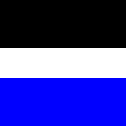

In [8]:
imgTest = Image.open(imgList[2]) 
imgTest

In [6]:
tensor(imgTest)[120:130, 120:130]

tensor([[[  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255]],

        [[  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255]],

        [[  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255]],

        [[  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255]],

        [[  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255],
         [  0,   0, 255, 255]],

        [[  0,   0, 255, 255],
         [  0,   0, 255, 255]